How does the traffic of Taxi rides change along the day?

In order to answer this question, I would use K-means clustering to cluster New York into different groups based on location, and analyze the traffic into and out of every cluster as a function of the time along the day. One can expect that residential areas would have more incoming traffic in the evening, whereas commercial areas would mostly attract people during the day, and areas with rich nightlife would show more traffic in the night. 

This can be helpful in duration prediction, as we can learn what are the likely destinations for each area during different times of the day.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from subprocess import check_output


### Read the data

In [2]:
data_dir   = "./data/"
x_test_add = "x_test_additional_file.csv"
x_test     = "x_test.csv"
x_train_add= "x_train_additional_file.csv"
x_train    = "x_train.csv"
y_train    = "y_train_u9upqBE.csv"
classes_path = "data_classes.pkl"


In [3]:
df = pd.read_csv(os.path.join(data_dir, x_train))
df.columns = df.columns.str.replace(' ', '_')

In [4]:
df.head()

emergency_vehicle_selection  intervention  alert_reason_category  \
0                      5105452      13264186                      3   
1                      4720915      12663715                      3   
2                      5365374      13675521                      3   
3                      4741586      12695745                      3   
4                      5381209      13698743                      3   

   alert_reason  intervention_on_public_roads  floor  location_of_the_event  \
0          2162                             0      0                  148.0   
1          2124                             0      1                  136.0   
2          2163                             0      2                  139.0   
3          2162                             0      0                  136.0   
4          2162                             0      3                  104.0   

   longitude_intervention  latitude_intervention  emergency_vehicle  ...  \
0                2.284796              48.879669               4511  ...   
1                2.247464              48.818191               4327  ...   
2                2.258328              48.836759               4509  ...   
3                2.393832              48.776526               5731  ...   
4                2.458610              48.875751               5623  ...   

  delta_status_preceding_selection-selection  departed_from_its_rescue_center  \
0                                       2027                                1   
1                                      28233                                1   
2                                       1981                                0   
3                                       1842                                1   
4                                       2716                                1   

  longitude_before_departure  latitude_before_departure  \
0                   2.288053                  48.884698   
1                   2.268519                  48.823958   
2                   2.272944                  48.850498   
3                   2.388940                  48.787732   
4                   2.439331                  48.863814   

   delta_position_gps_previous_departure-departure  \
0                                              NaN   
1                                              NaN   
2                                             33.0   
3                                              NaN   
4                                              NaN   

                   GPS_tracks_departure-presentation  \
0  2.289000,48.885113;2.288861,48.884998;2.288000...   
1                                                NaN   
2  2.272972,48.850498;2.269056,48.847443;2.262611...   
3              2.394278,48.782112;2.393639,48.776833   
4  2.439472,48.863724;2.439583,48.863777;2.440917...   

          GPS_tracks_datetime_departure-presentation  \
0  2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...   
1                                                NaN   
2  2018-11-16 10:14:31;2018-11-16 10:15:43;2018-1...   
3            2018-01-15 00:42:46;2018-01-15 00:43:58   
4  2018-11-24 00:37:10;2018-11-24 00:38:22;2018-1...   

                                       OSRM_response  OSRM_estimated_distance  \
0  {"code":"Ok","routes":[{"geometry":"}yjiH}x}L_...                    952.5   
1  {"code":"Ok","routes":[{"geometry":"u|~hHy`zL_...                   2238.5   
2  {"code":"Ok","routes":[{"geometry":"_cdiHo}zLm...                   3026.4   
3  {"code":"Ok","routes":[{"geometry":"sywhH_pqMy...                   1934.2   
4  {"code":"Ok","routes":[{"geometry":"wvfiHgn{Mj...                   2706.7   

   OSRM_estimated_duration  
0                    105.8  
1                    243.2  
2                    295.4  
3                    166.6  
4                    262.6  

[5 rows x 26 columns]

### Remove rides to and from far away areas

In [5]:
xlim = [2.15, 2.6]
ylim = [48.61, 49.06]
df = df[(df.longitude_before_departure> xlim[0]) & (df.longitude_before_departure < xlim[1])]
df = df[(df.longitude_intervention> xlim[0]) & (df.longitude_intervention < xlim[1])]
df = df[(df.latitude_before_departure> ylim[0]) & (df.latitude_before_departure < ylim[1])]
df = df[(df.latitude_intervention> ylim[0]) & (df.latitude_intervention < ylim[1])]

### Plot rides

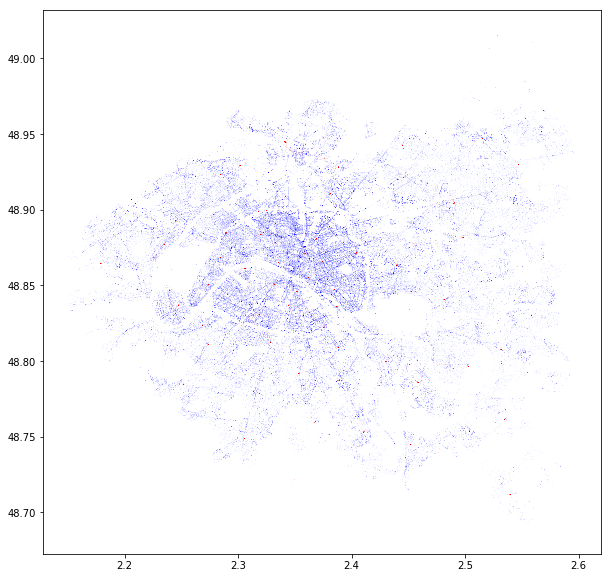

In [6]:
plt.figure(figsize = (10,10))

longitude = list(df.longitude_intervention)
latitude =  list( df.latitude_intervention)
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05, color='b')

longitude = list(df.longitude_before_departure)
latitude =  list( df.latitude_before_departure)
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05, color='r')
plt.show()

In [6]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

# Times visualisation

In [8]:
df = pd.read_csv(os.path.join(data_dir, y_train))
df.columns = df.columns.str.replace(' ', '_')
print(df.dtypes)

emergency_vehicle_selection     int64
delta_selection-departure       int64
delta_departure-presentation    int64
delta_selection-presentation    int64
dtype: object


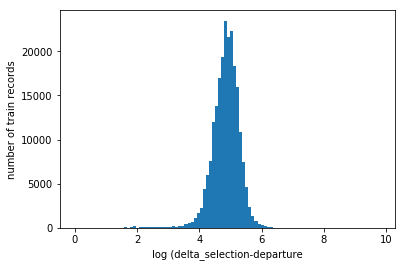

In [21]:
k = 'delta_selection-departure'
plt.hist(np.log(df[k].values +1), bins=100)
plt.xlabel('log ('+k)
plt.ylabel('number of train records')
plt.show()

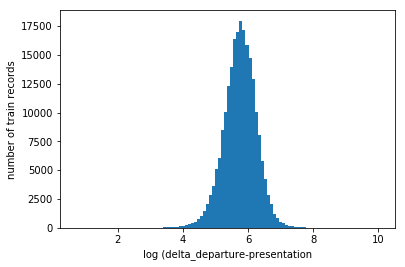

In [14]:
k = 'delta_departure-presentation'
plt.hist(np.log(df[k].values+1), bins=100)
plt.xlabel('log ('+k)
plt.ylabel('number of train records')
plt.show()

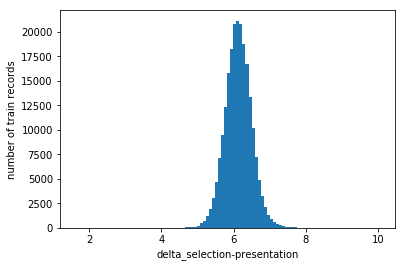

In [15]:
k = 'delta_selection-presentation'
plt.hist(np.log(df[k].values+1), bins=100)
plt.xlabel(k)
plt.ylabel('number of train records')
plt.show()